In [1]:
import numpy as np
import pandas as pd

from scipy.stats import binom, uniform

from plotnine import ggplot, geom_line, geom_segment, geom_point
from plotnine import theme_matplotlib, scale_x_log10, scale_y_log10
from plotnine import aes, labs, guides, guide_legend, options

In [2]:
options.figure_size = (7.4, 4.8)
joonised_kaust = 'tees/joonised/'

$\DeclareMathOperator*{\MEAN}{\mathbf{E}}$
$\DeclareMathOperator*{\VARIANCE}{\mathbf{D}}$
$\newcommand{\mean}[1]{\MEAN\left[#1\right]}$
$\newcommand{\variance}[1]{\VARIANCE\left[#1\right]}$
$\newcommand{\prob}[1]{\Pr\left[#1\right]}$
$\newcommand{\accuracy}{Acc}$
$\newcommand{\precision}{Prec}$
$\newcommand{\recall}{Rec}$

## Õigsuse lähendi relatiivne viga
Lisaks ligikaudse väärtuse absoluutsele veale kasutatakse lähendi headuse mõõtmiseks relatiivset viga. Õigsuse lähendi relatiivse vea keskväärtus ja dispersioon avalduvad järgnevalt
\begin{align*}
    \mean{\frac{\widehat{\accuracy}}{\accuracy}-1}&=\frac{1}{\accuracy}\cdot\mean{\widehat{\accuracy}}-1=1-1=0 \nonumber\enspace, \\
    \variance{\frac{\widehat{\accuracy}}{\accuracy}-1}&=\frac{1}{\accuracy^2}\cdot\frac{\accuracy\cdot(1-\accuracy)}{N}=\frac{1}{N}\cdot\frac{1-\accuracy}{\accuracy} \enspace.
\end{align*}
Uurides lähendi relatiivse ja absoluutse vea hajuvuse suhet
\begin{equation*}
    \variance{\frac{\widehat{\accuracy}}{\accuracy}} : \variance{\widehat{\accuracy}-\accuracy}=
    \left( \frac{1}{N}\cdot\frac{1-\accuracy}{\accuracy} \right) : \left( \frac{1}{N}\cdot \accuracy\cdot(1-\accuracy) \right)=\frac{1}{\accuracy^2} \enspace,
\end{equation*}
selgub, et kõrge õigsuse korral on õigsuse lähendi vead ligikaudu sama hajuvusega.

Nagu absoluutse veahinnangu puhul on ka relatiivse veahinnangu puhul eesmärk seda absoluutväärtuselt minimeerida. Seega võib küsida kui suurt valimit läheb vaja, et piisavalt suure kindlusega oleks relatiivne viga võimalikult väike.

Õigsuse lähend sisaldab binoomjaotusega juhuslikku suurust. Järelikult on võimalik relatiivset viga tõenäosuslikult hinnata kasutades binoomjaotuse omadusi. Lähtudes võrrandist
\begin{equation}
    \label{eq:binoomjaotus relatiivne viga}
    \prob{\left|\frac{\widehat{\accuracy}}{\accuracy}-1\right|\geq\varepsilon}=\alpha \enspace,
\end{equation}
millest tõenäosusmärgi aluses võrratuses eraldada binoomjaotusega juhusliku suuruse $S_N$ ühele poole võrratusemärki
\begin{align*}
    \prob{S_N \leq N \cdot \accuracy \cdot (1-\varepsilon)} &= \frac{\alpha}{2} \enspace, \\
    \prob{S_N <    N \cdot \accuracy \cdot (1+\varepsilon)} &= 1 - \frac{\alpha}{2} \enspace,
\end{align*}
avalduvad olulisusele vastavad protsendipunktid kujul
\begin{align*}
    q_1 &= N \cdot \accuracy \cdot (1-\varepsilon) \enspace, \\
    q_2 &= N \cdot \accuracy \cdot (1+\varepsilon) \enspace.
\end{align*}

Relatiivse vea tõkkeks $\varepsilon$ võrrandist \eqref{eq:binoomjaotus relatiivne viga} on valitud suurem protsendipunktide põhjal avalduv veahinnang
\begin{equation*}
    \varepsilon = \max \left( 1 - \frac{q_1}{N\cdot\accuracy} , \frac{q_2}{N\cdot\accuracy} - 1 \right) \enspace.
\end{equation*}
Tulemuse põhjal saab arvutada valimi vajalikud suurused olulisuse suhtes.

| $\accuracy$ | $\varepsilon = 10\%$ | $\varepsilon = 1\%$ | $\varepsilon = 0.1\%$ |
|-------------|----------------------|---------------------|-----------------------|
| $70\%$      | $161$                | $16331$             | $1646727$             |
| $90\%$      | $53$                 | $4176$              | $425856$              |
| $95\%$      | $3$                  | $1926$              | $202223$              |

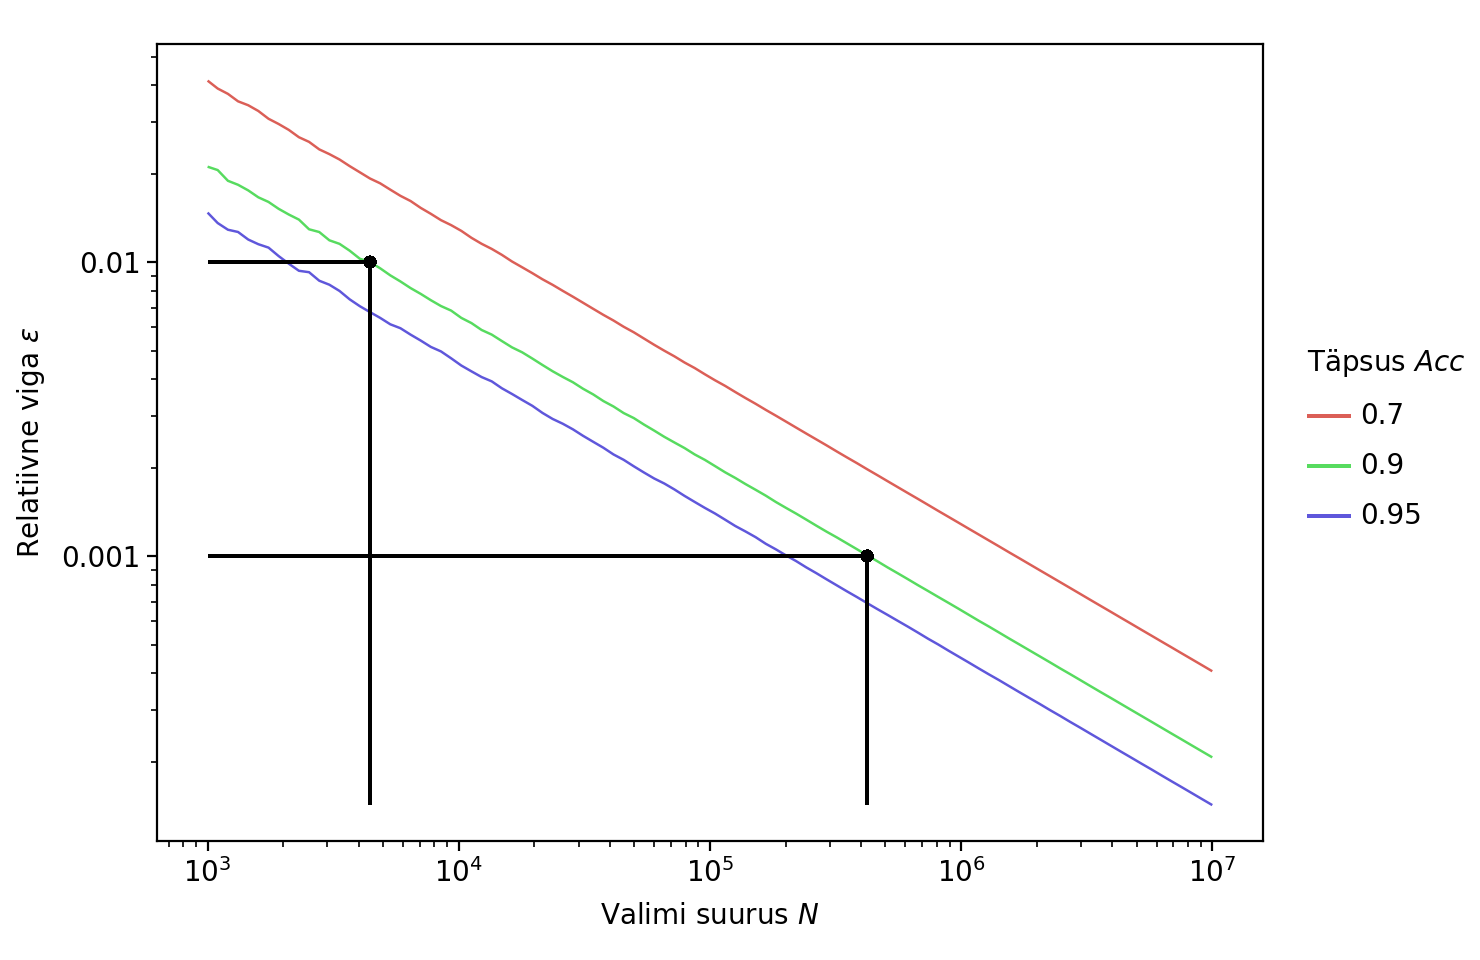

<Figure Size: (740 x 480)>

In [3]:
N = np.round(np.logspace(3, 7, 100), 0)  # binom.ppf() ei salli komakohti ???
tõenäosused = 0.7, 0.9, 0.95

read = [
    (
        p, n, max(1 - binom.ppf(q=0.025, p=p, n=n) / (n * p), binom.ppf(q=1-0.025, p=p, n=n) / (n * p) - 1)
    ) for p in tõenäosused for n in N
]
df = pd.DataFrame(read, columns=['tõenäosus', 'n', 'epsilon'])

p90 = df.query('tõenäosus == .9')
n_p90_e01 = p90.iloc[np.abs(p90['epsilon'] - 0.01).argmin()]['n']
n_p90_e001 = p90.iloc[np.abs(p90['epsilon'] - 0.001).argmin()]['n']
eps_min = df['epsilon'].min()

g = (
    ggplot(df) + theme_matplotlib() +
    
    labs(x='Valimi suurus $N$', y='Relatiivne viga $\\varepsilon$') +
    guides(color=guide_legend(title='Täpsus $Acc$')) +
    
    scale_x_log10(breaks=np.logspace(3, 7, 5), labels=['$10^3$','$10^4$', '$10^5$', '$10^6$', '$10^7$']) +
    scale_y_log10(breaks=np.logspace(-3, -1, 3)) +
    
    geom_line(aes('n', 'epsilon', group='tõenäosus', color='pd.Categorical(tõenäosus)')) +
    
    geom_segment(aes(x=1e3, y=1e-2, xend=n_p90_e01, yend=1e-2)) +
    geom_segment(aes(x=1e3, y=1e-3, xend=n_p90_e001, yend=1e-3)) +
    geom_segment(aes(x=n_p90_e01, y=eps_min, xend=n_p90_e01, yend=1e-2)) +
    geom_segment(aes(x=n_p90_e001, y=eps_min, xend=n_p90_e001, yend=1e-3)) +
    
    geom_point(aes(x='n_p90_e01', y='1e-2')) + geom_point(aes(x='n_p90_e001', y='1e-3'))
)
# g.save(joonised_kaust + 'binoomjaotus_relatiivne_viga.png', dpi=100)
g

Tabelis ja joonisel on esitatud valimi vajalikud suurused meetodi oletatud õigsuse ja relatiivse veahinnangu soovitud suuruse suhtes binoomjaotuse omaduste põhjal kindlusega $95\%$.